In [1]:
# import libraries
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pyfolio as pf
import warnings
import requests
import bs4 as bs
from bs4 import BeautifulSoup
import random
warnings.filterwarnings('ignore')

c:\Users\ezlik\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# 1. Crossover with Simple Moving Average

In [2]:
class CrossoverSMA():

    def __init__(self, symbol: str, SMA_S: int = 50, SMA_L: int = 100, start : str = "2018-01-01", end=datetime.datetime.now().date()):
        '''
        symbol: ticker symbol
        SMA_S: short term Simple Moving Average
        SMA_L: long term Simple Moving Average
        '''

        self.symbol = symbol
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.start = start
        self.end = end
        self.get_data()

    def get_data(self):

        # extract data
        data = yf.download(self.symbol, start=self.start, end=self.end).loc[:, "Close"].to_frame()

        # create technical indicators (Simple Moving Average)
        data["SMA_S"] = data["Close"].rolling(window=self.SMA_S, min_periods = 1).mean()
        data["SMA_L"] = data["Close"].rolling(window=self.SMA_L, min_periods = 1).mean()

        # position
        data["signal"] = np.where(data["SMA_S"] > data["SMA_L"], 1, 0)
        data["position"] = data["signal"].diff()
        
        # Buy and Sell signals
        buysignals = data[data["position"] == 1]
        sellsignals = data[data["position"] == -1]

        # calculate buy_and_hold
        data["buy_and_hold"] = np.log(data["Close"] / data["Close"].shift(1))

        # calculate strategy buy_and_hold
        data["strategy"] = data["signal"].shift(1) * data["buy_and_hold"]

        # drop NA
        data.dropna(inplace=True)
        
        # set date as index
        data.reset_index(inplace=True)
        data.set_index('Date', inplace=True)

        # assign to self
        self.data = data
        self.buysignals = buysignals
        self.sellsignals = sellsignals

        return data, buysignals, sellsignals

    def performance_summary(self):

        # calculate sum
        print("Sum of returns:")
        print(self.data[["buy_and_hold", "strategy"]].sum(), "\n")
        print("#" * 50)

        # calculate what $1 would be worth
        print("What $1 would be worth:")
        print(self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp), "\n")
        print("#" * 50)

        # calculate performance metrics
        print("Performance metrics:")
        pf.show_perf_stats(self.data["strategy"])
        print("#" * 50)

        # Plot graph
        self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 8))
        plt.legend(loc="upper left")
        plt.title(f"{self.symbol} Crossover with SMA {self.SMA_S} and SMA {self.SMA_L}")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        # plot main graph
        self.data[["Close"]].plot(figsize=(10, 8), color="gray", zorder=1)
        plt.title(f"Buy and Sell signals of {self.symbol}")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        # plot moving averages
        plt.plot(self.data["SMA_S"], color="orange", label=f"SMA {self.SMA_S}", zorder=1)
        plt.plot(self.data["SMA_L"], color="blue", label=f"SMA {self.SMA_L}", zorder=1)

        # plot buy and sell signals
        plt.scatter(self.buysignals.index, self.data["SMA_S"][self.data["position"] == 1], marker="^", color="green", label="Buy", zorder=2)
        plt.scatter(self.sellsignals.index, self.data["SMA_S"][self.data["position"] ==-1], marker="v", color="red", label="Sell", zorder=2)

        plt.legend()
        plt.show()

[*********************100%***********************]  1 of 1 completed
Sum of returns:
buy_and_hold    0.941528
strategy        0.520471
dtype: float64 

##################################################
What $1 would be worth:
            buy_and_hold  strategy
Date                              
2018-01-03      1.017061  1.000000
2018-01-04      1.021012  1.000000
2018-01-05      1.034551  1.000000
2018-01-08      1.038203  1.000000
2018-01-09      1.036880  1.000000
...                  ...       ...
2023-10-02      2.500349  1.641110
2023-10-03      2.467923  1.619827
2023-10-04      2.520290  1.654198
2023-10-05      2.517122  1.652119
2023-10-06      2.563897  1.682820

[1450 rows x 2 columns] 

##################################################
Performance metrics:


Start date,2018-01-03
End date,2023-10-06
Total months,69
,Backtest
Annual return,6.9%
Cumulative returns,46.7%
Annual volatility,21.8%
Sharpe ratio,0.41
Calmar ratio,0.15
Stability,0.53
Max drawdown,-45.1%


##################################################


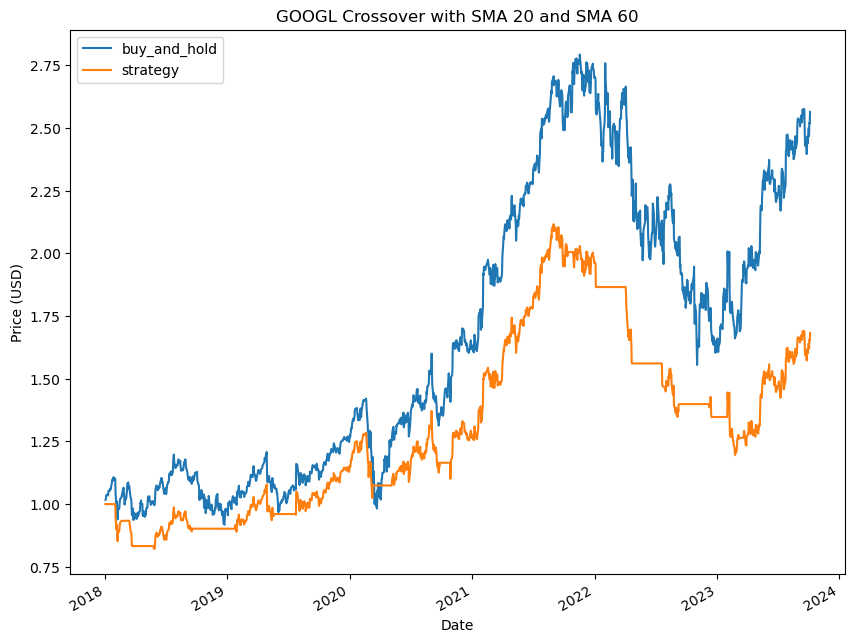

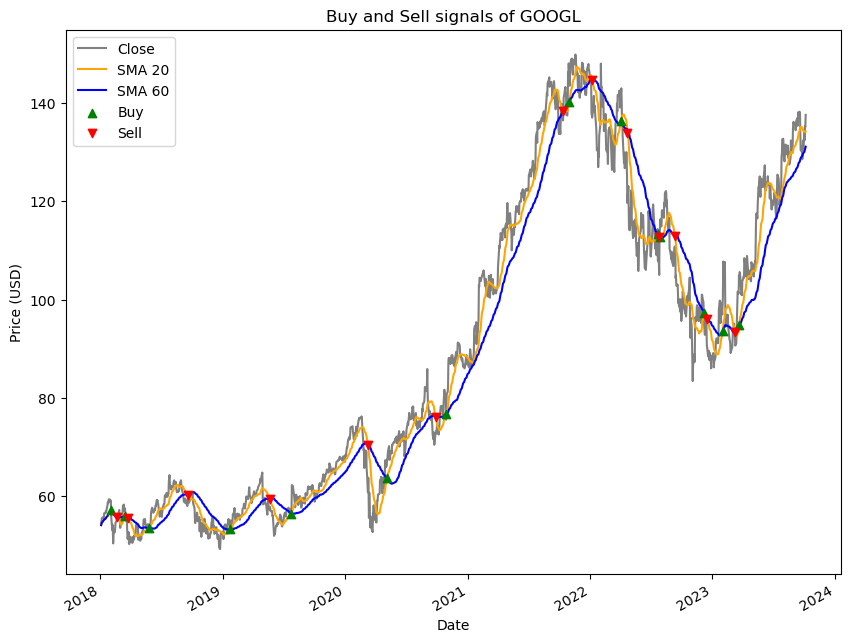

In [16]:
ticker = CrossoverSMA(symbol="GOOGL", SMA_S=20, SMA_L=60, start="2018-01-01", end=datetime.datetime.now().date())
ticker.performance_summary()

In [12]:
# Create an empty DataFrame to store the performance statistics
compiled_data = pd.DataFrame()

sp500_tickers = ["AAPL", "AMD", "MSFT", "AMZN", "GOOGL", "JPM", "META", "TSLA", "V", "JNJ",
    "PG", "NVDA", "MA", "HD", "UNH", "VZ", "NFLX", "DIS", "PYPL", "ADBE"]

# Loop through the ticker symbols
for ticker_symbol in sp500_tickers:

    # Instantiate the strategy class with the current ticker symbol
    ticker = CrossoverSMA(symbol=ticker_symbol, SMA_S=20, SMA_L=60, start="2022-01-01", end=datetime.datetime.now().date())
    
    # Calculate performance statistics for the strategy
    performance_stats = pf.timeseries.perf_stats(ticker.data["strategy"])
    
    # Create a new row as a DataFrame with the ticker symbol as the index
    new_row = pd.DataFrame([performance_stats], index=[ticker_symbol])
    
    # Concatenate the new row to the compiled_data DataFrame
    compiled_data = pd.concat([compiled_data, new_row], axis=0)

# Rename the columns of the compiled_data DataFrame
compiled_data.columns = [col for col in compiled_data.columns]

# sort the index
compiled_data.sort_index(inplace=True)

# Add average values to the compiled_data DataFrame
average_row = compiled_data.mean()

# Create a new row as a DataFrame
average_row = pd.DataFrame([average_row], index=["average"])

# Concatenate the average_row to the DataFrame
compiled_data = pd.concat([compiled_data, average_row], axis=0)

# round the values
compiled_data = compiled_data.round(3)

# Print the compiled_data DataFrame
compiled_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk
AAPL,-0.023,-0.042,0.163,-0.062,-0.106,0.000,-0.218,0.984,-0.087,-0.365,8.154,1.081,-0.021
ADBE,-0.051,-0.089,0.228,-0.113,-0.176,0.195,-0.288,0.973,-0.152,-0.751,5.877,1.108,-0.029
AMD,-0.017,-0.030,0.314,0.103,-0.043,0.057,-0.388,1.027,0.149,0.304,8.256,1.112,-0.039
AMZN,-0.056,-0.099,0.265,-0.086,-0.178,0.059,-0.316,0.980,-0.124,0.286,7.169,0.956,-0.033
DIS,-0.199,-0.330,0.150,-1.404,-0.531,0.905,-0.375,0.580,-1.697,-2.202,24.885,0.529,-0.020
GOOGL,-0.126,-0.217,0.225,-0.489,-0.335,0.260,-0.378,0.885,-0.642,-0.946,10.597,0.927,-0.029
HD,-0.037,-0.065,0.147,-0.179,-0.201,0.234,-0.183,0.954,-0.241,-0.788,9.695,0.957,-0.019
JNJ,-0.046,-0.081,0.109,-0.377,-0.288,0.565,-0.159,0.902,-0.532,0.746,17.823,0.762,-0.014
JPM,-0.035,-0.063,0.144,-0.176,-0.246,0.268,-0.142,0.956,-0.231,-0.933,8.236,1.029,-0.018
MA,-0.110,-0.190,0.167,-0.615,-0.423,0.243,-0.260,0.868,-0.819,-0.439,5.898,0.928,-0.021


In [18]:
compiled_data.to_csv('compiled_data_SMA.csv', index=True)

# 2. Crossover with Exponential Weighted Average

In [4]:
class CrossoverEMA():
    
        def __init__(self, symbol, EMA_S, EMA_L, start, end=datetime.datetime.now().date()):
            self.symbol = symbol
            self.EMA_S = EMA_S
            self.EMA_L = EMA_L
            self.start = start
            self.end = end
            self.get_data()
            
    
        def get_data(self):
            # extract data
            data = yf.download(self.symbol, start=self.start, end=self.end).loc[:, "Close"].to_frame()
    
            # create technical indicators (Exponential Moving Average)
            data["EMA_S"] = data["Close"].ewm(span = self.EMA_S).mean()
            data["EMA_L"] = data["Close"].ewm(span = self.EMA_L).mean()

            # position
            data["signal"] = np.where(data["EMA_S"] > data["EMA_L"], 1, 0)
            data["position"] = data["signal"].diff()

            # Buy and Sell signals
            buysignals = data[data["position"] == 1]
            sellsignals = data[data["position"] == -1]            
  
            # calculate buy_and_hold
            data["buy_and_hold"] = np.log(data["Close"] / data["Close"].shift(1))
    
            # calculate strategy buy_and_hold
            data["strategy"] = data["signal"].shift(1) * data["buy_and_hold"]

            # drop NA
            data.dropna(inplace=True)
            
            # set date as index
            data.reset_index(inplace=True)
            data.set_index('Date', inplace=True)

            # assign to self
            self.data = data
            self.buysignals = buysignals
            self.sellsignals = sellsignals

            return data, buysignals, sellsignals

        def performance_summary(self):

            # calculate sum
            print("Sum of returns:")
            print(self.data[["buy_and_hold", "strategy"]].sum(), "\n")
            print("#" * 50)

            # calculate what $1 would be worth
            print("What $1 would be worth:")
            print(self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp), "\n")
            print("#" * 50)

            # calculate performance metrics
            print("Performance metrics:")
            pf.show_perf_stats(self.data["strategy"])
            print("#" * 50)

            # Plot graph
            self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 8))
            plt.legend(loc="upper left")
            plt.title(f"{self.symbol} Crossover with EMA {self.EMA_S} and EMA {self.EMA_L}")
            plt.ylabel("Price (USD)")
            plt.xlabel("Date")

            # plot buy and sell signals
            self.data[["Close"]].plot(figsize=(10, 8), color="gray", zorder=1)
            plt.title(f"Buy and Sell signals of {self.symbol}")
            plt.ylabel("Price (USD)")
            plt.xlabel("Date")

            # plot moving averages
            plt.plot(self.data["EMA_S"], color="orange", label=f"EMA {self.EMA_S}", zorder=1)
            plt.plot(self.data["EMA_L"], color="blue", label=f"EMA {self.EMA_L}", zorder=1)

            # plot buy and sell signals
            plt.scatter(self.buysignals.index, self.data["EMA_S"][self.data["position"] == 1], marker="^", color="green", label="Buy", zorder=2)
            plt.scatter(self.sellsignals.index, self.data["EMA_S"][self.data["position"] ==-1], marker="v", color="red", label="Sell", zorder=2)            

            plt.legend()
            plt.show()            

In [13]:
# Create an empty DataFrame to store the performance statistics
compiled_data = pd.DataFrame()

sp500_tickers = ["AAPL", "AMD", "MSFT", "AMZN", "GOOGL", "JPM", "META", "TSLA", "V", "JNJ",
    "PG", "NVDA", "MA", "HD", "UNH", "VZ", "NFLX", "DIS", "PYPL", "ADBE"]

# Loop through the ticker symbols
for ticker_symbol in sp500_tickers:

    # Instantiate the strategy class with the current ticker symbol
    ticker = CrossoverEMA(symbol=ticker_symbol, EMA_S=21, EMA_L=42, start="2022-01-01", end=datetime.datetime.now().date())
    
    # Calculate performance statistics for the strategy
    performance_stats = pf.timeseries.perf_stats(ticker.data["strategy"])
    
    # Create a new row as a DataFrame with the ticker symbol as the index
    new_row = pd.DataFrame([performance_stats], index=[ticker_symbol])
    
    # Concatenate the new row to the compiled_data DataFrame
    compiled_data = pd.concat([compiled_data, new_row], axis=0)

# Rename the columns of the compiled_data DataFrame
compiled_data.columns = [col for col in compiled_data.columns]

# sort the index
compiled_data.sort_index(inplace=True)

# Add average values to the compiled_data DataFrame
average_row = compiled_data.mean()

# Create a new row as a DataFrame
average_row = pd.DataFrame([average_row], index=["average"])

# Concatenate the average_row to the DataFrame
compiled_data = pd.concat([compiled_data, average_row], axis=0)

# round the values
compiled_data = compiled_data.round(3)

# Print the compiled_data DataFrame
compiled_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk
AAPL,0.006,0.010,0.158,0.114,0.032,0.180,-0.176,1.029,0.165,-0.081,7.505,1.085,-0.020
ADBE,0.033,0.061,0.222,0.259,0.120,0.002,-0.277,1.063,0.361,-0.465,5.707,1.082,-0.028
AMD,-0.145,-0.247,0.316,-0.340,-0.318,0.298,-0.457,0.916,-0.488,0.420,7.787,0.992,-0.040
AMZN,-0.104,-0.179,0.237,-0.344,-0.296,0.188,-0.350,0.919,-0.474,-0.168,7.237,0.998,-0.030
DIS,-0.184,-0.307,0.152,-1.255,-0.578,0.813,-0.318,0.631,-1.561,-1.742,22.692,0.526,-0.020
GOOGL,-0.084,-0.147,0.218,-0.295,-0.282,0.063,-0.300,0.927,-0.394,-0.859,11.538,0.968,-0.028
HD,-0.051,-0.090,0.143,-0.293,-0.323,0.400,-0.158,0.923,-0.382,-1.234,12.924,0.974,-0.018
JNJ,-0.113,-0.195,0.109,-1.044,-0.532,0.802,-0.212,0.775,-1.341,-0.667,6.785,0.793,-0.014
JPM,-0.011,-0.021,0.145,-0.007,-0.091,0.222,-0.126,0.998,-0.009,-1.118,10.319,0.967,-0.018
MA,-0.135,-0.230,0.184,-0.694,-0.372,0.184,-0.361,0.854,-0.941,0.011,6.654,0.925,-0.024


In [21]:
compiled_data.to_csv('compiled_data_EMA.csv', index=True)

# 3. Crossover with RSI

In [6]:
class CrossoverEMA_RSI():

    def __init__(self, symbol, EMA_S, EMA_L, RSI_window, start, end=datetime.datetime.now().date()):

        self.symbol = symbol
        self.EMA_S = EMA_S
        self.EMA_L = EMA_L
        self.RSI_window = RSI_window
        self.start = start
        self.end = end
        self.get_data()
    
    def get_data(self):

        # extract data
        data = yf.download(self.symbol, start=self.start, end=self.end).loc[:, "Close"].to_frame()

        # create technical indicators (Exponential Moving Average)
        data["EMA_S"] = data["Close"].ewm(span = self.EMA_S).mean()
        data["EMA_L"] = data["Close"].ewm(span = self.EMA_L).mean()

        # calculate RSI
        data.ta.rsi(length=self.RSI_window, close=data["Close"], append=True, append_to_df=True)

        # generate buy and sell signals
        rsi_threshold = 30
        buysignals = data[(data["EMA_S"] > data["EMA_L"]) | (data[f"RSI_{self.RSI_window}"] <= rsi_threshold)]
        sellsignals = data[(data["EMA_S"] < data["EMA_L"]) | (data[f"RSI_{self.RSI_window}"] >= 100 - rsi_threshold)]

        # position
        data["position"] = np.where((data["EMA_S"] > data["EMA_L"]) | (data[f"RSI_{self.RSI_window}"] <= rsi_threshold), 1, -1)

        # buy and hold
        data["buy_and_hold"] = np.log(data["Close"] / data["Close"].shift(1))

        # strategy
        data["strategy"] = data["position"].shift(1) * data["buy_and_hold"]
    
        # drop NA
        data.dropna(inplace=True)

        # set date as index
        data.reset_index(inplace=True)
        data.set_index('Date', inplace=True)

        # assign to self
        self.data = data
        self.buysignals = buysignals
        self.sellsignals = sellsignals

        return data, buysignals, sellsignals     

    def performance_summary(self):

        # calculate sum
        print("Sum of returns:")
        print(self.data[["buy_and_hold", "strategy"]].sum(), "\n")
        print("#" * 50)

        # calculate what $1 would be worth
        print("What $1 would be worth:")
        print(self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp), "\n")
        print("#" * 50)

        # calculate performance metrics
        print("Performance metrics:")
        pf.show_perf_stats(self.data["strategy"])
        print("#" * 50)

        # Plot graph
        self.data[["buy_and_hold", "strategy"]].cumsum().apply(np.exp).plot(figsize=(10, 8))
        plt.legend(loc="upper left")
        plt.title(f"{self.symbol} Crossover with EMA {self.EMA_S} and EMA {self.EMA_L} & RSI {self.RSI_window} days")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        # plot buy and sell signals
        self.data[["Close"]].plot(figsize=(10, 8), color="gray", zorder=1)
        plt.title(f"Crossover with EMA of {self.EMA_S}, {self.EMA_L} & RSI {self.RSI_window} for {self.symbol}")
        plt.ylabel("Price (USD)")
        plt.xlabel("Date")

        # plot moving averages
        plt.plot(self.data["EMA_S"], color="orange", label=f"EMA {self.EMA_S}", zorder=1)
        plt.plot(self.data["EMA_L"], color="blue", label=f"EMA {self.EMA_L}", zorder=1)

        # plot buy and sell signals
        plt.scatter(self.buysignals.index, self.buysignals["Close"], marker="^", color="green", label="Buy", zorder=2)
        plt.scatter(self.sellsignals.index, self.sellsignals["Close"], marker="v", color="red", label="Sell", zorder=2)            

        plt.legend()
        plt.show()
       


In [14]:
# Create an empty DataFrame to store the performance statistics
compiled_data = pd.DataFrame()

sp500_tickers = ["AAPL", "AMD", "MSFT", "AMZN", "GOOGL", "JPM", "META", "TSLA", "V", "JNJ",
    "PG", "NVDA", "MA", "HD", "UNH", "VZ", "NFLX", "DIS", "PYPL", "ADBE"]

# Loop through the ticker symbols
for ticker_symbol in sp500_tickers:

    # Instantiate the strategy class with the current ticker symbol
    ticker = CrossoverEMA_RSI(symbol=ticker_symbol, EMA_S=21, EMA_L=42, RSI_window=14, start="2022-01-01", end=datetime.datetime.now().date())
    
    # Calculate performance statistics for the strategy
    performance_stats = pf.timeseries.perf_stats(ticker.data["strategy"])
    
    # Create a new row as a DataFrame with the ticker symbol as the index
    new_row = pd.DataFrame([performance_stats], index=[ticker_symbol])
    
    # Concatenate the new row to the compiled_data DataFrame
    compiled_data = pd.concat([compiled_data, new_row], axis=0)

# Rename the columns of the compiled_data DataFrame
compiled_data.columns = [col for col in compiled_data.columns]

# sort the index
compiled_data.sort_index(inplace=True)

# Add average values to the compiled_data DataFrame
average_row = compiled_data.mean()

# Create a new row as a DataFrame
average_row = pd.DataFrame([average_row], index=["average"])

# Concatenate the average_row to the DataFrame
compiled_data = pd.concat([compiled_data, average_row], axis=0)

# round the values
compiled_data = compiled_data.round(3)

# Print the compiled_data DataFrame
compiled_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk
AAPL,0.105,0.192,0.302,0.483,0.403,0.536,-0.262,1.085,0.720,0.033,1.658,1.308,-0.037
ADBE,0.050,0.090,0.405,0.321,0.118,0.209,-0.425,1.057,0.490,0.856,6.520,1.040,-0.050
AMD,-0.290,-0.452,0.556,-0.340,-0.405,0.640,-0.717,0.945,-0.489,0.271,1.364,1.034,-0.071
AMZN,-0.008,-0.013,0.440,0.200,-0.018,0.200,-0.429,1.035,0.308,0.748,3.444,1.070,-0.055
DIS,0.141,0.260,0.330,0.562,0.440,0.049,-0.319,1.100,0.846,0.509,4.791,1.063,-0.041
GOOGL,-0.039,-0.067,0.361,0.072,-0.124,0.113,-0.313,1.012,0.100,-0.206,1.844,1.068,-0.045
HD,0.028,0.050,0.274,0.238,0.104,0.256,-0.271,1.042,0.345,0.141,3.695,0.999,-0.034
JNJ,-0.050,-0.086,0.172,-0.212,-0.189,0.257,-0.265,0.964,-0.290,-0.312,3.478,0.999,-0.022
JPM,0.141,0.260,0.260,0.636,0.638,0.077,-0.220,1.113,0.878,-0.501,1.755,1.014,-0.032
MA,-0.322,-0.494,0.265,-1.334,-0.548,0.534,-0.588,0.793,-1.745,-0.205,2.719,0.787,-0.035


In [24]:
compiled_data.to_csv('compiled_data_EMA_RSI.csv', index=True)